# Calibrate GAM and NGAM

In [1]:
import pandas as pd
from reframed import FBA, Environment, load_cbmodel, save_cbmodel
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = load_cbmodel('../models/RcH10_v2.xml')

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media_cellb = media[media.medium=='DM_cellobiose']
env_cellb = Environment.from_compounds(list(media_cellb['compound']))
env_cellb.apply(model, inplace=True, exclusive=True, warning=False)

In [4]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values

In [5]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=0
model.reactions.Growth.stoichiometry['M_adp_c']=0
model.reactions.Growth.stoichiometry['M_h_c']=0
model.reactions.Growth.stoichiometry['M_pi_c']=0

In [6]:
max_atp=[]

for q_i, mu_i in zip(q_cellb, mu):
    constraints = {
        'R_EX_cellb_e': (-q_i, -q_i),
        'Growth':(mu_i, mu_i),
        'R_EX_so4_e':(-2.45,1000),
        'R_EX_pi_e':(-7.46,1000),
        'R_EX_nh4_e':(-4.9,1000)
    }
    sol = FBA(model, constraints=constraints, objective={'R_ATPM': 1})
    max_atp.append(sol.fobj)

In [18]:
A = np.vstack([mu, np.ones((1,7))]).T
b = np.array(max_atp).T
opt = lsq_linear(A, b)#, bounds=[(0, 0), (100, 10)])
GAM, NGAM = round(opt.x[0], 1), round(opt.x[1], 1)

In [19]:
print(f'GAM:{GAM} NGAM: {NGAM}')

GAM:55.4 NGAM: 6.6


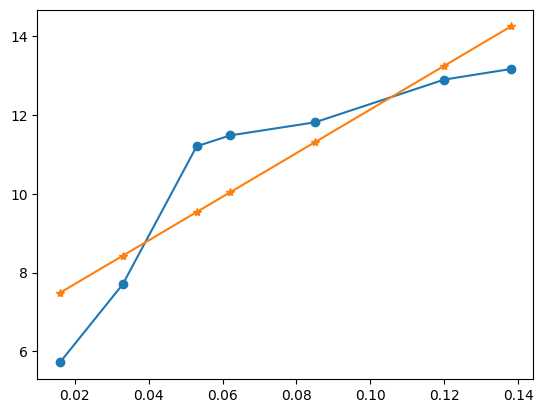

In [9]:
plt.plot(mu, max_atp, 'o-')
plt.plot(mu, NGAM + GAM*mu,  '*-')

In [10]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=-GAM
model.reactions.Growth.stoichiometry['M_adp_c']=GAM
model.reactions.Growth.stoichiometry['M_h_c']=GAM
model.reactions.Growth.stoichiometry['M_pi_c']=GAM

In [11]:
#Setting NGAM values in the ATPM function
model.reactions.R_ATPM.lb = NGAM

In [12]:
## pFBA prediction of growth rate and product production
mu_sim = []

for q_i in q_cellb:
    sol = FBA(model, constraints={'R_EX_cellb_e': (-q_i, 0)})
    mu_i = sol.fobj if sol.fobj is not None else 0
    mu_sim.append(mu_i)

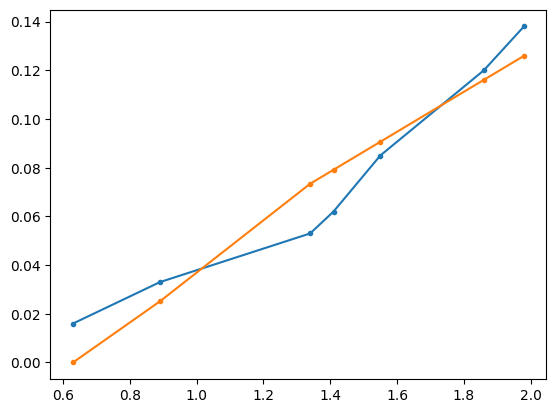

In [13]:
plt.plot(q_cellb, mu, '.-')
plt.plot(q_cellb, mu_sim, '.-')

In [14]:
save_cbmodel(model, '../models/RcH10_final.xml')